# Snook

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from PIL import Image
from typing import Tuple
from utils import plot_inference

import numpy as np
import os
import snook.data as sd
import snook.utils as su
import torch
import torch.nn as nn
import torch.nn.functional as F

## Detection and Classification

In [2]:
class Snook(nn.Module):
    def __init__(self, autoencoder: str, classifier: str) -> None:
        super(Snook, self).__init__()
        self.autoencoder = torch.jit.load(autoencoder)
        self.classifier  = torch.jit.load(classifier)
        
    def forward(self, x: torch.Tensor, alpha=0.45) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        heatmap = torch.clamp(self.autoencoder(x.unsqueeze(0))[0, 0], 0, 1)
        heatmap[heatmap < alpha] = 0

        peaks = su.peak_detection(heatmap)
        windows = su.peak_windows(render, peaks)

        logits = self.classifier(windows)
        probas = torch.softmax(logits, dim=0)
        labels = torch.argmax(probas, dim=-1)

        return heatmap, peaks, labels
    

snook = Snook("models/autoencoder.ts", "models/classifier.ts").eval().cuda()

In [3]:
dataset = sd.ReMaHeDataset("dataset/test/renders", "dataset/test/data", spread=4.0)

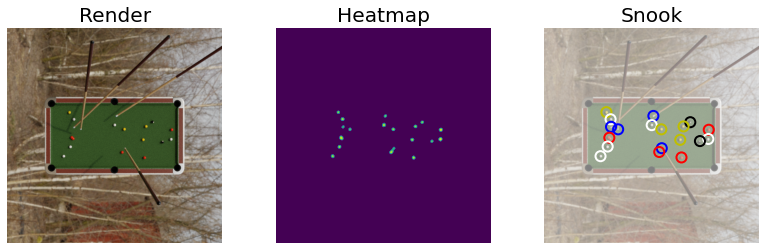

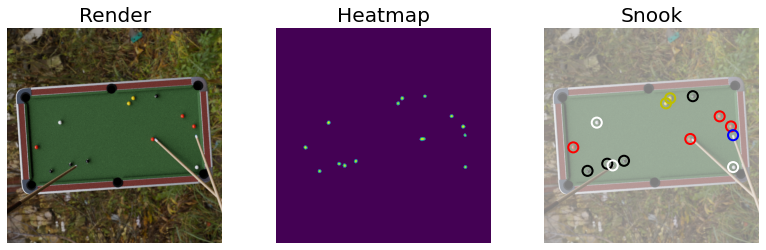

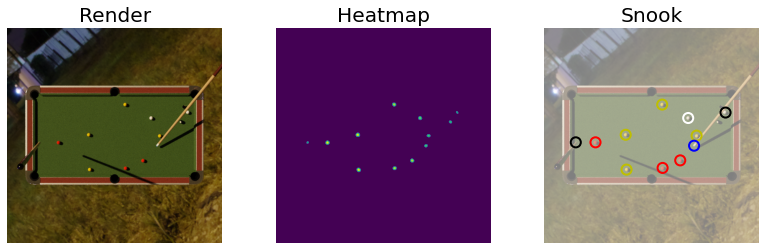

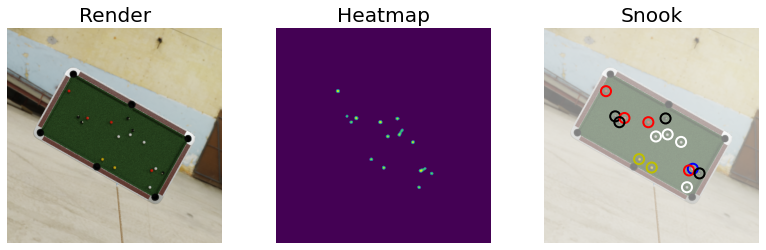

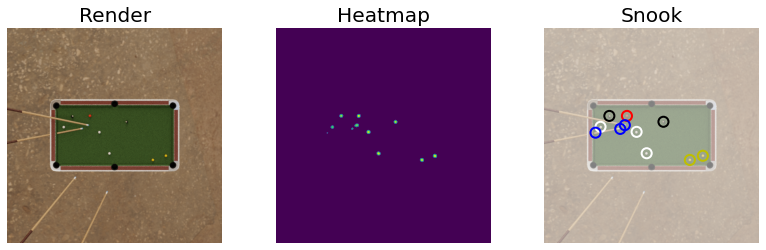

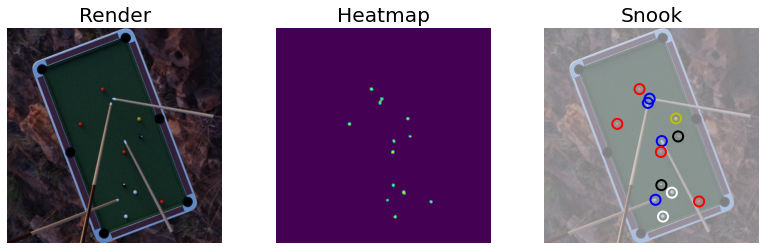

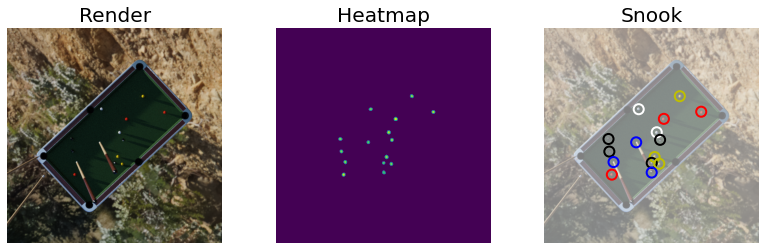

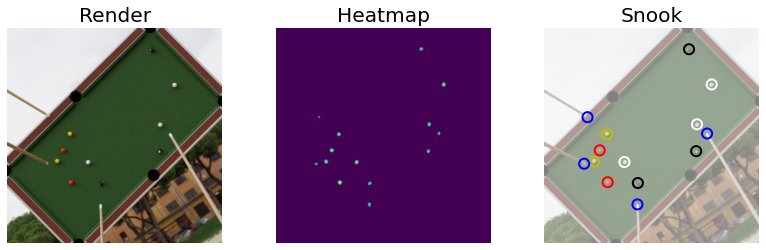

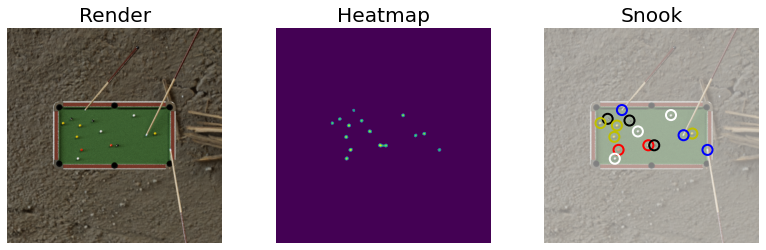

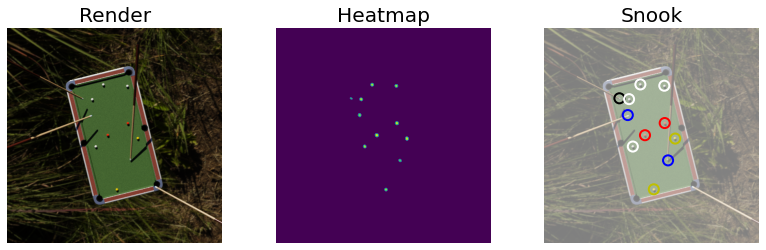

In [4]:
for i in range(10):
    render, _, _ = dataset[i]
    render = render.cuda()
    heatmap, peaks, labels = snook(render)
    plot_inference(render, heatmap, peaks, labels)

## Performances

In [5]:
snook.cpu()

print("CPU Performances:")
%timeit snook.autoencoder(torch.rand(1, 3, 512, 512))
%timeit snook.classifier(torch.rand(1, 3, 64, 64))

CPU Performances:
43.6 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1 ms ± 9.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
snook.cuda()

print("GPU Performance:")
%timeit snook.autoencoder(torch.rand(1, 3, 512, 512).cuda())
%timeit snook.classifier(torch.rand(1, 3, 64, 64).cuda())

GPU Performance:
10.2 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
880 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Out of Domain

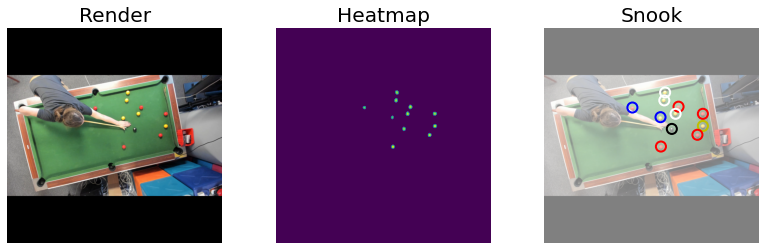

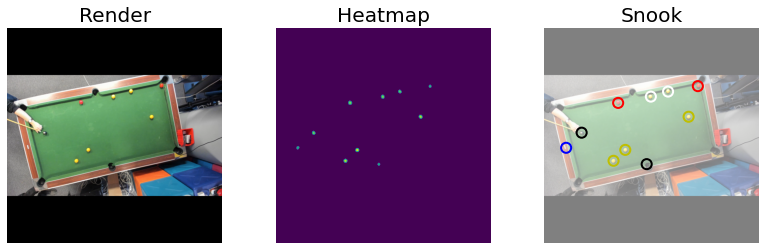

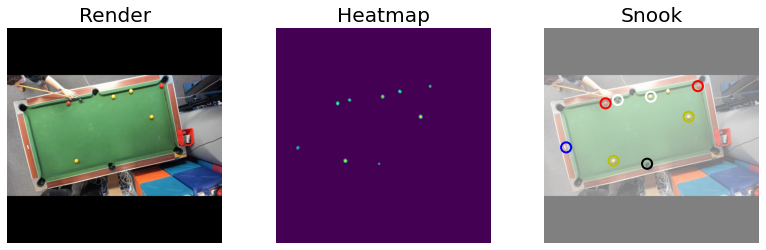

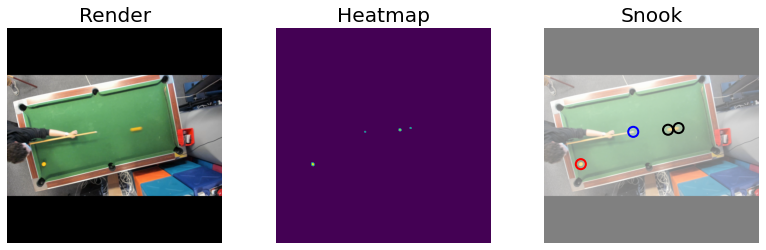

In [7]:
for path in [f"dataset/ood_{i + 1}.png" for i in range(4)]:
    img = np.array(sd.ResizeSquare(512)(Image.open(path).convert("RGB"))) / 255.0
    render = torch.Tensor(img).permute((2, 0, 1))
    render = render.cuda()
    heatmap, peaks, labels = snook(render)
    plot_inference(render, heatmap, peaks, labels)